In [21]:
from lmfit import Model, Parameters
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

In [22]:
def make_param_0():
    params = Parameters()
    # n_pre = dict0['n']

    # for i in range(n_pre):
    #     params.add(f"K{i}", dict0[f'K{i}'], vary = False) #min=0.9*dict0[f'K{i}'], max=1.1*dict0[f'K{i}'])
    #     params.add(f"b{i}", dict0[f'b{i}'], vary = False) #min=0.9*dict0[f'b{i}'], max=1.1*dict0[f'b{i}'])
    #     params.add(f"c{i}", dict0[f'c{i}'], vary = False) #min=0.9*dict0[f'c{i}'], max=1.1*dict0[f'c{i}'])
    #     params.add(f"d{i}", dict0[f'd{i}'], vary = False) #min=0.9*dict0[f'c{i}'], max=1.1*dict0[f'c{i}'])

    # for i in np.arange(n_pre,n):
    #     params.add(f"K{i}", 10, min=0)
    #     params.add(f"b{i}", 100, min=dict0[f'b{i-1}'])
    #     params.add(f"c{i}", 0.01, min=0)
    #     params.add(f"d{i}", 0, min=0)
    params.add(f"K", 10, min=0, max=100)
    params.add(f"b", 1, min=1e-2, max=100)
    params.add(f"c", 1, min=1e-6, max=2)
    #params.add(f"d", 0, min=0)

    return params

# Define the Gompertz bell curve function
def gompertz(t, K, b, c):
    return K*b*c*np.exp(-c*(t))*np.exp(-b*np.exp(-c*(t)))

# Fit on the S curve
def cum_gompertz(t, K, b, c):
    return np.cumsum(gompertz(t, K, b, c)) # + (cum_pos[-1]-d-np.cumsum(richardson(t, K, r, tm, nu))[-1])/(t[-1]-t[0])*(t-t[0])

# Dayly correction
def err_by_day(data, fit):
    sub_data=data[-7:0:-7]
    sub_fit=fit[-7:0:-7]
    err=0.4*(sub_fit-sub_data)/sub_data
    return np.mean(err)

In [23]:
national_data=pd.read_csv('..\data\dati-andamento-nazionale\dpc-covid19-ita-andamento-nazionale.csv')
new_pos_tot=national_data['nuovi_positivi'].values[:]
cum_pos_tot=np.cumsum(new_pos_tot)
T_tot=new_pos_tot.shape[0]

C:\Users\adria\AppData\Local\Temp\ipykernel_24796\4203953026.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = mpl.cm.get_cmap('viridis', T_tot-t0)


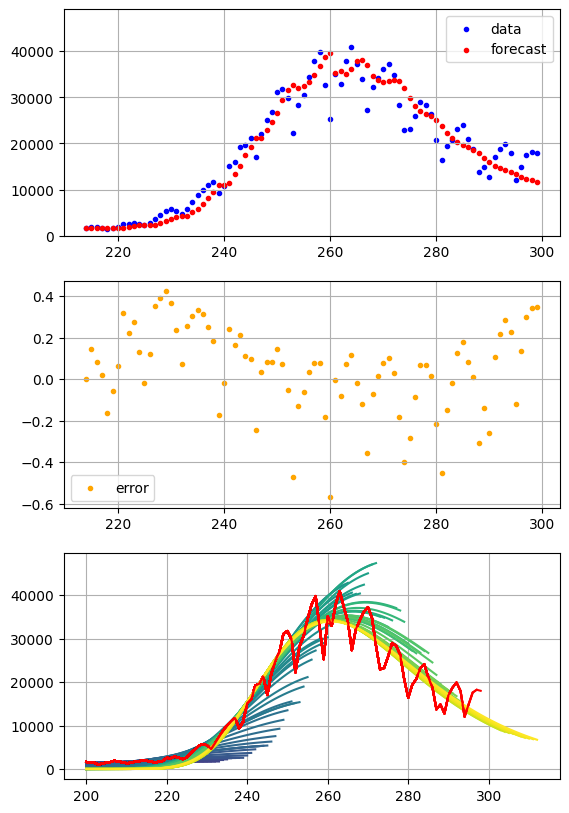

In [24]:
t0=200
T_tot = 300
fig, ax = plt.subplots(3,1)
fig.set_figheight(10)
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[0].set_ylim(0,1.2*np.amax(new_pos_tot[t0:T_tot]))
param_list=[]
for t in range(t0+14,T_tot):
    new_pos = new_pos_tot[t0:t]  # Data acquisition
    cum_pos = np.cumsum(new_pos)
    if t==t0+14:
        norm_factor = np.amax(new_pos)
    else:
        norm_factor = np.amax(new_pos)
    data = new_pos/norm_factor # Normalization
    cum_data = np.cumsum(data)
    d0 = cum_data[0]
    tt=np.arange(t0,t)
    tt_forecast=np.arange(t0,t+14)

    # Create model
    if t==t0+14:
        params = make_param_0()
    else:
        params=result.params
    fmodel= Model(gompertz)

    # fit the model
    result = fmodel.fit(data, params, t=tt-t0, max_nfev=10000)
    sigma = result.eval_uncertainty()
    if t==t0+14:
        forecast=new_pos[-1]
        err=0
    else:
        forecast = fit[t-t0]
        err = err_by_day(new_pos[:-1], fit[0:t-1-t0])
    fit = norm_factor*gompertz(tt_forecast-t0, result.params['K'].value, result.params['b'].value, result.params['c'].value)
    
    # Saving parameters
    param_list.append([result.params['K'].value, result.params['b'].value, result.params['c'].value])

    # Visualization
    ax[0].scatter(t,new_pos[-1], color='b', marker='.')
    ax[0].scatter(t,forecast, color='r', marker='.')
    #ax[0].scatter(t,forecast*(1-err), color='g', marker='.')
    ax[1].scatter(t,(new_pos[-1]-forecast)/new_pos[-1], color='orange', marker='.')
    # ax[1].scatter(t,abs(new_pos[-1]-forecast*(1-err))/new_pos[-1], color='magenta', marker='.')
    # ax[1].annotate("",
    #         xy=(t, abs(new_pos[-1]-forecast*(1-err))/new_pos[-1]), xycoords='data',
    #         xytext=(t, abs(new_pos[-1]-forecast)/new_pos[-1]), textcoords='data',
    #         arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    viridis = mpl.cm.get_cmap('viridis', T_tot-t0)
    ax[2].plot(tt_forecast, fit, color=viridis((t-t0)/(T_tot-t0)), label=f't={t}')
    ax[2].plot(tt, new_pos, color='red')


ax[0].legend(['data','forecast'])
ax[1].legend(['error'])
plt.show()


        

[[Model]]
    Model(gompertz)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 99
    # variables        = 3
    chi-square         = 0.57700236
    reduced chi-square = 0.00601044
    Akaike info crit   = -503.357849
    Bayesian info crit = -495.572489
    R-squared          = 0.93546741
[[Variables]]
    K:  45.4358891 +/- 1.04439446 (2.30%) (init = 45.09998)
    b:  20.5152944 +/- 1.63663971 (7.98%) (init = 20.99038)
    c:  0.04965139 +/- 0.00143822 (2.90%) (init = 0.05013241)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, c) = +0.9597
    C(K, c) = -0.7327
    C(K, b) = -0.6933


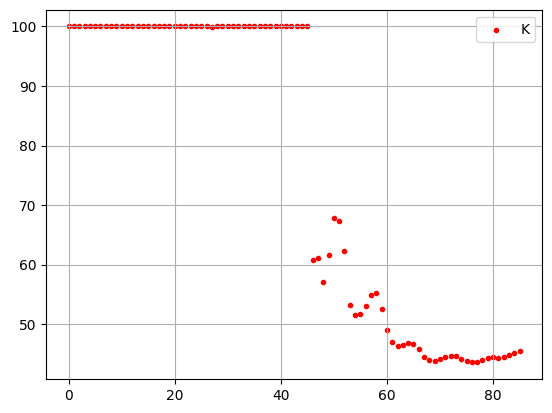

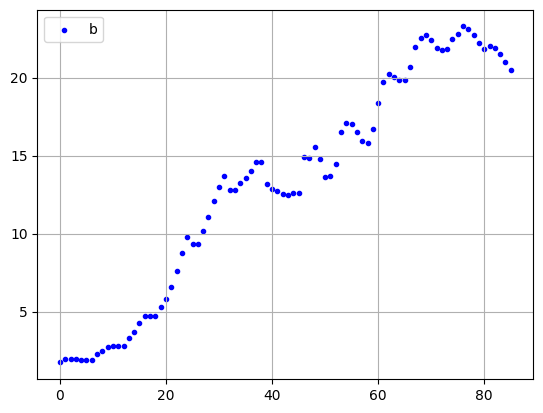

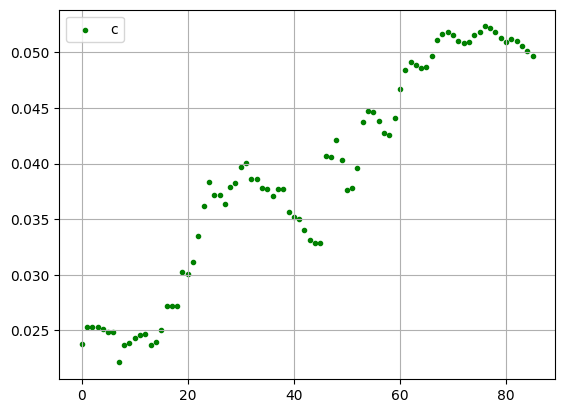

In [25]:
print(result.fit_report())

labels=['K','b','c']
colors=['r','b','g']
for i in range(3):
    plt.figure()
    for j in range(len(param_list)):
        plt.scatter(j,param_list[j][i], marker='.',color=colors[i])
    plt.grid(True)
    plt.legend(labels[i])
    plt.show()

In [ ]:
import Forecast as fc

